# Klebsiella RBP-R prediction framework

This is the main notebook for the Klebsiella phage-host interaction prediction based on phage RBPs and Klebsiella's K-locus. The idea is to start with something simple and add on to it iteratively.

The first simple framework is as follows:
1. Identify the K locus on the bacterial genome using Kaptive
2. Transform the locus into an embedding using Word2Vec
3. Transform the RBP sequence into an embedding using UniRep, ProtTransBert, SeqVec, ...
4. Construct reliable negative interactions by random sampling with constraints that make sense (use RBPs and loci to create similarity scores)
5. Concatenate and train an RF model via cross-validation

## 0 - Libraries and directories

In [37]:
import os
import math
import random
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from Bio import SeqIO
from Bio.Blast import NCBIWWW, NCBIXML
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from Bio.Blast.Applications import NcbiblastpCommandline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from bio_embeddings.embed import Word2VecEmbedder, ProtTransBertBFDEmbedder, SeqVecEmbedder
%matplotlib inline

In [2]:
# set project directory (to locate Kaptive), data directory and results directory
project_dir = '/Users/dimi/Documents/GitHub_Local/PhageHostLearning'
data_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Klebsiella_RBP_data'
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS'
cdpath = '/opt/anaconda3/pkgs/cd-hit-4.8.1-hd9629dc_0/bin'

## 1 - Identify the K locus using Kaptive

In [4]:
def kaptive_python(project_dir, data_dir, database_name, file_name):
    """
    This function is a wrapper for the Kaptive Python file to be executed from another Python script.
    This wrapper runs on a single FASTA file (one genome) and also produces a single FASTA file.
    
    Input:
    - project_directory: the location of kaptive.py (preferrably in the same project folder)
    - data_directory: location of the database and sequence file(s) to loop over
    - database_name: string of the name of the database (.gbk file)
    - file_name: string of the file name (FASTA)
    
    Output:
    - a single fasta file of the locus (single piece or multiple ones) per genome
    """
    cd_command = 'cd ' + project_dir
    
    kaptive_command = 'python kaptive.py -a ' + data_dir + '/' + file_name + ' -k ' + data_dir + '/' + database_name + ' -o ' + data_dir + '/ --no_table --no_json'
    command = cd_command + '; ' + kaptive_command
    ssprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    ssout, sserr = ssprocess.communicate()
    kaptive_file_name = 'kaptive_results_'+file_name
    
    return kaptive_file_name, ssout, sserr

In [6]:
def compute_loci(klebsiella_genomes, project_dir, data_dir, database_name):
    """
    This function uses kaptive_python to loop over all klebsiella_genomes, construct FASTA files for
    each of them and identify their loci. Importantly, the file_names are later used to construct embeddings,
    so need to be identifiable (accession numbers).
    
    EITHER work with phagebase_1 genomes, or with RBPbase accession numbers, what's best?
    
    Input:
    - klebsiella_genomes: Pandas DataFrame of genomes w/ following column names:
        'accession', 'sequence' and 'number_of_prophages'
    - project_directory: the location of kaptive.py (preferrably in the same project folder)
    - data_directory: location of the database and sequence file(s) to loop over
    - results_directory: location to store results
    - database_name: string of the name of the database (.gbk file)
    """
    kaptive_file_names = []
    pbar = tqdm(total=klebsiella_genomes.shape[0])
    
    # loop over klebsiella_genomes
    for i, genome in enumerate(klebsiella_genomes['sequence']):
        #if klebsiella_genomes['number_of_prophages'][i] > 0: # no filter: rows/columns consistent down the road
        acc = klebsiella_genomes['accession'][i]

        # make FASTA file
        file_name = acc+'.fasta'
        fasta = open(data_dir+'/'+file_name, 'w')
        fasta.write('>'+acc+'\n'+genome+'\n')
        fasta.close()

        # run Kaptive
        kaptive_file, _, _ = kaptive_python(project_dir, data_dir, database_name, file_name)
        kaptive_file_names.append(kaptive_file)

        # delete FASTA file
        os.remove(data_dir+'/'+file_name)
            
        # update progress
        pbar.update(1)
            
    pbar.close()
    return kaptive_file_names

In [9]:
database = 'Klebsiella_k_locus_primary_reference.gbk'
genomes = pd.read_csv(data_dir+'/phagebase1_klebsiella_pneumoniae.csv')
names = compute_loci(genomes, project_dir, data_dir, database) # results in the same data_dir

100%|██████████| 376/376 [13:00:28<00:00, 124.54s/it]   


## 2 - Transform locus into embeddings

In [13]:
def locus_embeddings(kaptive_file_names, data_dir):
    """
    This functions computes Word2Vec embeddings for bacterial genomic loci. It uses the bio-embeddings
    package together with BioPython to transform fasta sequences of bacterial loci into numerical embeddings.
    
    WARNING: running this on a personal laptop without GPU can be slow (not advised). Best to start a Google
    Colab notebook and run the computations in the cloud.
    
    Input:
    - kaptive_file_names: list of fasta filenames of bacterial loci (output of Kaptive)
    - data_dir: location of the sequence file(s) to loop over
    - results_dir: directory to store the resulting embeddings in.
    
    Output:
    - embeddings: Pandas DataFrame (as .csv file) with file names and their corresponding embedding
    """
    embedder = Word2VecEmbedder()
    embeddings_list = []

    for name in tqdm(kaptive_file_names):
        locus_sequence = ''
        # one or multiple records in fasta file
        for record in SeqIO.parse(data_dir+'/'+name, 'fasta'):
            locus_sequence += str(record.seq)
        
        # compute embedding
        embedding = embedder.embed(locus_sequence)
        reduced_embedding = embedder.reduce_per_protein(embedding)
        embeddings_list.append(reduced_embedding)
        
    embeddings_df = pd.concat([pd.DataFrame(kaptive_file_names), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(data_dir+'/locus_embeddings.csv', index=False)
    
    return      

In [14]:
locus_embeddings(names, data_dir, data_dir)

100%|██████████| 376/376 [00:29<00:00, 12.69it/s]


## 3 - Tranform RBP sequences into embeddings

In [74]:
def RBPbase_identifiers(rbp_data, data_dir):
    """
    This function adds unique IDs to all RBP sequences in the RBP database. As the unit for further
    processing is an RBP sequence, each RBP sequence should have a unique identifier.

    Input:
    - rbp_data: name of the RBP database (string)
    - data_dir: location of the database and where the fasta files will be stored (string)

    Output:
    - adjusted RBPbase (extra column with unique_ID)
    """
    if data_dir != '':
        data_dir = data_dir+'/'

    RBPbase = pd.read_csv(data_dir+rbp_data)
    unique_id_list = []
    phage_id_list = []
    for i, phage_nr in enumerate(RBPbase['phage_nr']):
        phage_id = str(phage_nr)+str(RBPbase['host'][i])
        # first RBP
        if phage_id not in phage_id_list:
            count = 0
            phage_id_list.append(phage_id)
            unique_id_list.append(phage_id+'_RBP'+str(count))
        # second, third, ... RBP
        else:
            count += 1
            unique_id_list.append(phage_id+'_RBP'+str(count))

    RBPbase['unique_ID'] = unique_id_list
    RBPbase.to_csv(data_dir+rbp_data)

    return

In [83]:
def RBPbase_species_filter(rbp_data, data_dir, species):
    """
    This function creates a subset of RBPbase for a specific host species for further processing.

    Input:
    - rbp_data: name of the RBP database (string)
    - data_dir: location of the database and where the fasta files will be stored (string)
    - species: the single species to create a subset for

    Output:
    - subset RBPbase
    """
    if data_dir != '':
        data_dir = data_dir+'/'
    RBPbase = pd.read_csv(data_dir+rbp_data)
    to_delete = [i for i, host in enumerate(RBPbase['host']) if host != species]
    RBPbase = RBPbase.drop(to_delete, axis=0)
    RBPbase = RBPbase.reset_index(drop=True)
    filepieces = rbp_data.split('.')
    RBPbase.to_csv(data_dir+filepieces[0]+'_'+species+'.'+filepieces[1], index=False)
    
    return

In [37]:
def RBPbase_fasta_processing(rbp_data, data_dir):
    """
    This function processes the RBP database from a Pandas DataFrame to individual fasta files that can be
    looped over to compute protein embeddings.

    Input:
    - rbp_data: name of the RBP DataFrame (string) in the data_dir, with protein sequences in column 'protein_seq'
    - data_dir: location of the database and where the fasta files will be stored (string)

    Output:
    - fasta files of each of the RBP sequences in the database
    - big fasta file of all sequences together (for pairwise alignments later)
    """
    if data_dir != '':
        data_dir = data_dir+'/'
    if results_dir != '':
        results_dir = results_dir+'/'

    rbp_file_names = []
    RBPbase = pd.read_csv(data_dir+rbp_data)
    big_fasta = open(data_dir+rbp_data.split('.')[0]+'.fasta', 'w')
    for i, sequence in enumerate(RBPbase['protein_seq']):
        unique_id = RBPbase['unique_ID'][i]
        rbp_file_names.append(unique_id+'.fasta')
        
        # write individual fasta
        fasta = open(data_dir+unique_id+'.fasta', 'w')
        fasta.write('>'+unique_id+'\n'+sequence+'\n')
        fasta.close()
        
        # write big fasta
        big_fasta.write('>'+unique_id+'\n'+sequence+'\n')
    big_fasta.close()

    return rbp_file_names

In [36]:
def protein_embeddings(rbp_file_names, data_dir):
    """
    This functions computes ProttransBERT embeddings for phage RBPs. It uses the bio-embeddings
    package together with BioPython to transform fasta sequences of phage RBPs into numerical embeddings.
    
    WARNING: running this on a personal laptop without GPU is very slow and not advised. Best to start a Google
    Colab or Kaggle notebook and run the computations in the cloud.
    
    Input:
    - rbp_file_names: list of fasta filenames of phage RBPs
    - data_dir: location of the sequence file(s) to loop over
    - results_dir: directory to store the resulting embeddings in
    
    Output:
    - embeddings: Pandas DataFrame (as .csv file) with file names and their corresponding embedding
    """
    embedder = ProtTransBertBFDEmbedder()
    embeddings_list = []
    
    if data_dir != '':
        data_dir = data_dir+'/'

    for name in tqdm(rbp_file_names):
        for record in SeqIO.parse(data_dir+name, 'fasta'):
            rbp_sequence = str(record.seq)
        
        embedding = embedder.embed(rbp_sequence)
        reduced_embedding = embedder.reduce_per_protein(embedding)
        embeddings_list.append(reduced_embedding)
        
    embeddings_df = pd.concat([pd.DataFrame(rbp_file_names), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(data_dir+'protein_embeddings.csv', index=False)
    
    return  

In [65]:
RBPbase_identifiers('RBPbase_250621.csv', data_dir)
RBPbase_species_filter('RBPbase_250621.csv', data_dir, 'klebsiella_pneumoniae')
rbp_file_names = RBPbase_fasta_processing('RBPbase_250621_klebsiella_pneumoniae.csv', data_dir)
pd.DataFrame(rbp_file_names, columns=['names']).to_csv(data_dir+'/rbp_file_names.csv', index=False)
#protein_embeddings(rbp_file_names, data_dir) # do in Google Colab or Kaggle

## 4 - Construct reliable negative interactions

In [4]:
def get_kaptive_file_names(klebsiella_genomes):
    """
    This function is a support function to recollect all kaptive file names without
    having to recompute all loci.
    
    Input: klebsiella genomes DataFrame (columns: 'accession', 'sequence' and 'number_of_prophages')
    Output: list kaptive_file_names
    """
    kaptive_file_names = []
    for acc in klebsiella_genomes['accession']:
        file_name = 'kaptive_results_'+acc+'.fasta'
        kaptive_file_names.append(file_name)
    return kaptive_file_names

In [5]:
def kaptive_fasta_processing(kaptive_file_names, data_dir):
    """
    This function processes all the separate bacterial loci FASTA files into one merged FASTA file for 
    further processing (pairwise alignments).
    
    Input:
    - kaptive_file_names: list of fasta filenames of bacterial loci (output of Kaptive)
    - data_dir: location of the sequence file(s) to loop over
    """
    kaptive_fasta_all = data_dir+'/kaptive_results_all.fasta'
    big_fasta = open(kaptive_fasta_all, 'w')
    for name in kaptive_file_names:
        kaptive_id = name.split('.fasta')[0].split('kaptive_results_')[1]
        locus_sequence = ''
        for record in SeqIO.parse(data_dir+'/'+name, 'fasta'):
            locus_sequence += str(record.seq)   
        big_fasta.write('>'+kaptive_id+'\n'+locus_sequence+'\n')
    big_fasta.close()

    return kaptive_fasta_all

In [6]:
def pairwise_alignment_julia(file_name, align_type, project_dir, n_threads='4'):
    """
    Input:
    - file_name: string of path to the FASTA file to loop over
    - align_type: type of alignment to execute ('DNA' or 'protein')
    - project_dir: project directory with julia file in it
    - n_threads: number of threads to use for multithreading (as string; default=4)
    
    Output:
    - a score matrix of pairwise ID%, named file_name + '_score_matrix.txt'
    """
    threads_command = 'export JULIA_NUM_THREADS=' + n_threads
    alias_command = 'alias julia="/Applications/Julia-1.5.app/Contents/Resources/julia/bin/julia"'
    cd_command = 'cd ' + project_dir
    pw_command = 'julia pairwise_alignment.jl ' + file_name + ' ' + align_type
    
    command = threads_command + '; ' + alias_command + '; ' + cd_command + '; ' + pw_command
    ssprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    ssout, sserr = ssprocess.communicate()
    
    return ssout, sserr

In [68]:
def cdhit_est_python(cdhit_path, data_dir, kaptive_file_names, kaptive_fasta, output_file, c=0.90, n=7):
    """
    This function executes CD-HIT-EST (DNA sequences) clustering commands from within Python. 
    To install CD-HIT, do so via conda: conda install -c bioconda cd-hit.
    
    Input:
        - cdhit_path: path to CD-HIT software
        - kaptive_file_names: list of file names for ordering
        - kaptive_fasta: FASTA file with locus sequences
        - output file: path to output (will be one FASTA file and one .clstr file)
        - c: threshold on identity for clustering
        - n: word length (7 for thresholds between 0.88 and 0.9, DNA level)
    """
    
    # perform clustering
    cd_command = 'cd ' + cdhit_path
    cluster_command = 'cd-hit-est -i ' + kaptive_fasta + ' -o ' + output_file + ' -c ' + str(c) + ' -n ' + str(n) + ' -d 0'
    command = cd_command + '; ' + cluster_command
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, stderr = process.communicate()
    
    # load results and process
    score_matrix = np.zeros((len(kaptive_file_names), len(kaptive_file_names)))
    clusters = open(output_file+'.clstr')
    cluster_iter = 0
    cluster_accessions = []
    for line in clusters.readlines():
        # new cluster
        if line[0] == '>':
            # finish old cluster if not first one
            if (cluster_iter > 0) and (len(cluster_accessions) > 1):
                indices = [kaptive_file_names.index('kaptive_results_'+acc+'.fasta') for acc in cluster_accessions]
                for i in range(len(indices)-1):
                    for j in range(i, len(indices)):
                        if indices[i] != indices[j]:
                            score_matrix[indices[i],indices[j]], score_matrix[indices[j],indices[i]] = c, c
                
            # initiate new cluster
            cluster_accessions = []
            cluster_iter += 1
            
        # in a cluster
        else:
            acc = line.split('>')[1].split('...')[0]
            cluster_accessions.append(acc)
            
    # finish last cluster
    if len(cluster_accessions) > 1:
        indices = [kaptive_file_names.index('kaptive_results_'+acc+'.fasta') for acc in cluster_accessions]
        for i in range(len(indices)-1):
            for j in range(i, len(indices)):
                score_matrix[i,j], score_matrix[j,i] = c, c
    
    # assess identicals
    np.fill_diagonal(score_matrix, 1)
    for i in range(len(kaptive_file_names)-1):
        for j in range(i, len(kaptive_file_names)):
            seq_li = ''; seq_lj = ''
            for record in SeqIO.parse(data_dir+'/'+kaptive_file_names[i], 'fasta'):
                seq_li += str(record.seq)
            for record in SeqIO.parse(data_dir+'/'+kaptive_file_names[j], 'fasta'):
                seq_lj += str(record.seq)
            if seq_li == seq_lj:
                score_matrix[i,j], score_matrix[j,i] = 1, 1
           
    np.savetxt(output_file+'_score_matrix.txt', score_matrix, fmt='%.3f')
            
    return stdout, stderr

In [8]:
def constrained_random_interaction_matrix(loci_similarities, loci_threshold, rbp_similarities, rbp_threshold,
                                          kaptive_file_names, rbp_file_names, rbp_data):
    """
    This function constructs an interaction matrix for training by adding known positive interactions
    and using similarity scores to sample negative interactions in a random manner, with constraints.
    
    Input:
    - loci_similarities, rbp_similarities: similarity score matrices (hosts m x m and phages n x n)
    - loci_threshold, rbp_threshold: thresholds above which not to consider negative interactions
    - kaptive_file_names, rbp_file_names: lists of names to construct known interactions
    - rbp_data: name of the RBP DataFrame (string) (columns: 'host_accession', 'unique_ID')
    
    Output:
    - interaction matrix
    """
    interaction_matrix = np.empty((len(kaptive_file_names), len(rbp_file_names)))
    interaction_matrix[:] = np.nan

    # fill in known interactions
    for i, host_acc in enumerate(rbp_data['host_accession']):
        rbp_id = rbp_data['unique_ID'][i]
        index_m = kaptive_file_names.index('kaptive_results_'+host_acc+'.fasta')
        index_n = rbp_file_names.index(rbp_id+'.fasta')
        interaction_matrix[index_m, index_n] = 1
    print('check? ', i == len(rbp_file_names)-1)
    
    # delete identicals
    # ... (+ sample until sum(sum(int_matrix)))
    
    # sample random RBP and bacterial locus
    iteration = 0
    while iteration < len(rbp_file_names):
        random_rbp = random.choice(range(len(rbp_file_names)))
        random_locus = random.choice(range(len(kaptive_file_names)))

        # construct reliable negative interaction within constraints
        if interaction_matrix[random_locus, random_rbp] != 1:
            # collect similar RBPs and their interacting loci
            rbp_similarities_row = rbp_similarities[random_rbp,:]
            rbp_threshold_indices = [index for index, sim in enumerate(rbp_similarities_row) if sim >= rbp_threshold]
            loci_threshold_indices = [index for thr_index in rbp_threshold_indices for index in range(interaction_matrix.shape[0]) 
                                      if interaction_matrix[index, thr_index] == 1]
            duplicates = [dup for dup in loci_threshold_indices if loci_threshold_indices.count(dup) > 1]

            # assess similarity between collected loci
            loci_similarities_row = loci_similarities[random_locus,:]
            loci_exceeding_threshold = [index for index in loci_threshold_indices if loci_similarities_row[index] 
                                        >= loci_threshold]
            if len(loci_exceeding_threshold) == 0:
                interaction_matrix[random_locus, random_rbp] = 0
                iteration += 1
    print(iteration)
    return interaction_matrix

In [72]:
# process kaptive loci
genomes = pd.read_csv(data_dir+'/phagebase1_klebsiella_pneumoniae.csv')
kaptive_file_names = get_kaptive_file_names(genomes)
kaptive_fasta_all = kaptive_fasta_processing(kaptive_file_names, data_dir)
kaptive_out = data_dir+'/kaptive_loci'
_, _ = cdhit_est_python(cdpath, data_dir, kaptive_file_names, kaptive_fasta_all, kaptive_out)

In [ ]:
# process RBP sequences
"""
cmd line: julia pairwise_alignment.jl "/Users/Dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Klebsiella_RBP_data/RBPbase_250621_klebsiella_pneumoniae.fasta" "protein"
takes about 30 mins
"""
pairwise_alignment_julia(data_dir+'/RBPbase_250621_klebsiella_pneumoniae.fasta', 'protein', project_dir)

In [76]:
# construct interaction matrix
genomes = pd.read_csv(data_dir+'/phagebase1_klebsiella_pneumoniae.csv')
kaptive_file_names = get_kaptive_file_names(genomes)
loci_sim = np.loadtxt(data_dir+'/kaptive_loci_score_matrix.txt')
loci_thr = 0.9
rbp_sim = np.loadtxt(data_dir+'/RBPbase_250621_klebsiella_pneumoniae.fasta_score_matrix.txt')
rbp_thr = 0.9
rbp_file_names = list(pd.read_csv(data_dir+'/rbp_file_names.csv')['names'])
rbpbase = pd.read_csv(data_dir+'/RBPbase_250621_klebsiella_pneumoniae.csv')
interaction_matrix = constrained_random_interaction_matrix(loci_sim, loci_thr, rbp_sim, rbp_thr, kaptive_file_names, 
                                                         rbp_file_names, rbpbase)

check?  True
1503


In [ ]:
# delete identical interactions
for i in range(rbp_sim.shape[0]-1):
    for j in range(i, rbp_sim.shape[0]):
        if (rbp_sim[i,j] == 1) and (i != j):
            # get the corresponding loci
            locus_i = list(np.where(interaction_matrix[:, i] == 1)[0])
            locus_j = list(np.where(interaction_matrix[:, j] == 1)[0])
            
            for li in locus_i:
                for lj in locus_j:
                    if loci_sim[li, lj] == 1: # if identical, delete
                        interaction_matrix[lj,j] = np.nan
print(sum(sum(interaction_matrix == 1)))

## 5 - Exploring the interaction space

In [21]:
# how many columns have only one known datapoint? Important for evaluation!
ratio = []
for i in range(10):
    interaction_matrix = constrained_random_interaction_matrix(loci_sim, loci_thr, rbp_sim, rbp_thr, kaptive_file_names, 
                                                         rbp_file_names, rbpbase)
    counter = 0
    for column in range(interaction_matrix.shape[1]):
        nr_interactions = interaction_matrix.shape[0] - sum(np.isnan(interaction_matrix[:,column]))
        if nr_interactions  == 1:
            counter += 1
    ratio.append(counter/interaction_matrix.shape[1])
ratio    

check?  True
1503
check?  True
1503
check?  True
1503
check?  True
1503
check?  True
1503
check?  True
1503
check?  True
1503
check?  True
1503
check?  True
1503
check?  True
1503


[0.3865602129075183,
 0.3872255489021956,
 0.38256819693945443,
 0.39454424484364603,
 0.37857618097139056,
 0.37391882900864937,
 0.3925482368596141,
 0.3819028609447771,
 0.38922155688622756,
 0.3912175648702595]

1.0 done!
0.95 done!
0.9 done!
0.85 done!
0.8 done!
0.75 done!
0.7 done!
0.6499999999999999 done!
0.6 done!
0.55 done!
0.5 done!


Text(0, 0.5, 'number of sequences under or equal to threshold')

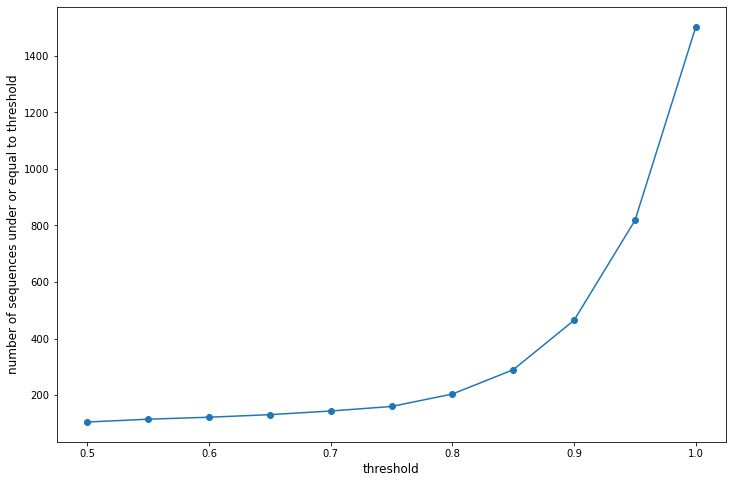

In [39]:
thresholds = np.linspace(1.0, 0.5, 11)
RBPmatrix = rbp_sim.copy()
np.fill_diagonal(RBPmatrix, 0) # exclude comparing the sequences themselves
total_number_seqs = []
for thres in thresholds:
    row = 0
    while row < RBPmatrix.shape[0]:
        if np.any(RBPmatrix[row,:] > thres):
            RBPmatrix = np.delete(RBPmatrix, row, 0)
            RBPmatrix = np.delete(RBPmatrix, row, 1)
        row += 1
    total_number_seqs.append(RBPmatrix.shape[0])
    print(thres, 'done!')

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(thresholds, total_number_seqs, marker='o')
ax.set_xlabel('threshold', size=12)
ax.set_ylabel('number of sequences under or equal to threshold', size=12)

<AxesSubplot:>

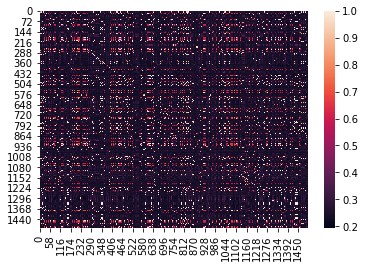

In [30]:
import seaborn as sns
sns.heatmap(rbp_sim)

## 5 - Processing into structured dataframe for training

In [105]:
def construct_training_dataframe(locus_features, rbp_features, interaction_matrix, RBPbase=0):
    """
    This function combines the seraparetly computed features of both the locus and the RBPs
    into one array suitable for training, considering the interaction matrix.
    
    At this point, the rows of the featuresets should correspond with the rows and columns of the interaction
    matrix, meaning the interaction matrix should be constructed starting from the same data as the features!
    
    Input:
    - locus features: DataFrame of the features constructed for the bacterial loci (m x #feats)
    - rbp_features: DataFrame of the features constructured for the phage RBPs (n x #feats)
    - interaction matrix: (m x n) with positives (1), negatives (0) and unknown (NaN)
    - RBPbase: RBP dataframe for sanity check (optional)
    
    TO DO: add rows and cols!
    """
    
    # define lists to append to
    locus_list = []; rbp_list = []; interaction_list = []; row_list = []; column_list = []
    
    # loop over interaction matrix and construct dataframe
    for i in range(interaction_matrix.shape[0]):
        for j in range(interaction_matrix.shape[1]):
            interaction = interaction_matrix[i,j]
            
            if math.isnan(interaction) == False:
                # make list of lists, that can subsequently be combined
                locus_list.append(list(locus_features.iloc[i,:]))
                rbp_list.append(list(rbp_features.iloc[j,:]))
                interaction_list.append(int(interaction))
                row_list.append(i)
                column_list.append(j)
            
            # sanity check (optional)
            if (interaction == 1) and (type(RBPbase) !=  int):
                locus_id = locus_em.index[i].split('kaptive_results_')[1].split('.fasta')[0]
                rbp_id = RBPbase['host_accession'][j]
                if locus_id != rbp_id:
                    print('mismatch!', rbp_id, locus_id)
    
    # concatenate to final dataframe
    training_dataframe = pd.concat([pd.DataFrame(locus_list), pd.DataFrame(rbp_list), pd.DataFrame(interaction_list),
                                    pd.DataFrame({'row': row_list})], axis=1)
    
    return training_dataframe     

In [106]:
locus_em = pd.read_csv(data_dir+'/locus_embeddings.csv', index_col=0)
rbp_em = pd.read_csv(data_dir+'/protein_embeddings.csv', index_col=0)
frame = construct_training_dataframe(locus_em, rbp_em, interaction_matrix, rbpbase)

## 6 - Machine learning models

In [96]:
# first simple test
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
outer_cv = StratifiedKFold(n_splits=4)
score_f1 = make_scorer(f1_score, average='weighted')
frame = np.asarray(frame)
perf_f1 = cross_val_score(rf, X=frame[:,:-1], y=frame[:,-1], scoring=score_f1, cv=outer_cv, verbose=False)

In [97]:
np.mean(perf_f1)

0.7643560945525851

In [113]:
from sklearn.model_selection import KFold
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
loci_cv = KFold(n_splits=5)
frame_array = np.asarray(frame.iloc[:,:-2])
labels = np.asarray(frame.iloc[:,-2])
fscores = []
for train_index, test_index in loci_cv.split(loci_sim):
    # construct training and test dataframe
    train_index_frame = []; test_index_frame = []
    for i, row_id in enumerate(frame['row']):
        if row_id in train_index:
            train_index_frame.append(i)
        else:
            test_index_frame.append(i)
    frame_train, frame_test = frame_array[train_index_frame], frame_array[test_index_frame]
    labels_train, labels_test = labels[train_index_frame], labels[test_index_frame]
    
    # fit a model
    rf.fit(frame_train, labels_train)
    
    # make predictions and test
    preds = rf.predict(frame_test)
    fscores.append(f1_score(labels_test, preds))

2080
2083
2089
2127
2149


In [112]:
np.mean(fscores)

0.6992311395518278

## X - Out of use